In [ ]:
# Drive mounting
from google.colab import drive
drive.mount('/content/drive/')

import sys
sys.path.append('/content/drive/My Drive/ADM-HW5/')

Mounted at /content/drive/


## Pre-processing

Download the data and store them in the main folder

In [ ]:
#!wget https://snap.stanford.edu/data/sx-stackoverflow-a2q.txt.gz
#!wget https://snap.stanford.edu/data/sx-stackoverflow-c2q.txt.gz
#!wget https://snap.stanford.edu/data/sx-stackoverflow-c2a.txt.gz

In [ ]:
#move file to directory name
#!mv /content/sx-stackoverflow-a2q.txt.gz /content/drive/MyDrive/ADM-HW5
#!mv /content/sx-stackoverflow-c2a.txt.gz /content/drive/MyDrive/ADM-HW5
#!mv /content/sx-stackoverflow-c2q.txt.gz /content/drive/MyDrive/ADM-HW5

Useful libraries

In [ ]:
!pip install BeautifulTable

In [1]:
import math
import gzip
import pandas as pd
import datetime
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import json
from beautifultable import BeautifulTable
import networkx as nx
import matplotlib.pyplot as plt
import collections
from collections import Counter
from collections import defaultdict
from collections import deque
from sys import maxsize as INT_MAX
import itertools
from joblib import Parallel, delayed
import scipy as sp
import scipy.sparse
import random
import functions as f

Read the file as cvs

In [ ]:
a2q = pd.read_csv('/content/drive/MyDrive/ADM-HW5/sx-stackoverflow-a2q.txt.gz', compression='gzip', header=None, sep=' ', quotechar='"', error_bad_lines=False)
c2a = pd.read_csv('/content/drive/MyDrive/ADM-HW5/sx-stackoverflow-c2a.txt.gz', compression='gzip', header=None, sep=' ', quotechar='"', error_bad_lines=False)
c2q = pd.read_csv('/content/drive/MyDrive/ADM-HW5/sx-stackoverflow-c2q.txt.gz', compression='gzip', header=None, sep=' ', quotechar='"', error_bad_lines=False)

Round dates to Year/Month/day (no minutes and seconds).
Furthermore, to reduce the dimensionality of our data, we only take dates from 2014 upwards.

In [ ]:
a2q[2] = pd.to_datetime(a2q[2], unit='s').apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day))

a2q = a2q[a2q[2] > '2014-01-01']

c2a[2] = pd.to_datetime(c2a[2], unit='s').apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day))
c2a = c2a[c2a[2] > '2014-01-01']

c2q[2] = pd.to_datetime(c2q[2], unit='s').apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day))
c2q = c2q[c2q[2] > '2014-01-01']

It's right we have dates from 2014 to 2016

In [ ]:
print(a2q[2].min())
print(a2q[2].max())

print(c2a[2].min())
print(c2a[2].max())

print(c2q[2].min())
print(c2q[2].max())

2014-01-02 00:00:00
2016-03-06 00:00:00
2014-01-02 00:00:00
2016-03-06 00:00:00
2014-01-02 00:00:00
2016-03-06 00:00:00


We transform dates into numbers (integers) to use them as keys in the dictionary.

In [ ]:
a2q[2] = a2q[2].dt.strftime('%Y%m%d').astype(int)
c2a[2] = c2a[2].dt.strftime('%Y%m%d').astype(int)
c2q[2] = c2q[2].dt.strftime('%Y%m%d').astype(int)

Delete the rows tha corresponds to answer/comments which the user answer/do themselves. We don't want a graph with nodes pointing to themselves.

In [ ]:
a2q.drop(a2q[a2q[1] == a2q[0]].index, inplace=True)
c2a.drop(c2a[c2a[1] == c2a[0]].index, inplace=True)
c2q.drop(c2q[c2q[1] == c2q[0]].index, inplace=True)

Create graph:

In [ ]:
#a2q graph
a2q_g = f.create_graph_1(a2q)
with open('/content/drive/MyDrive/ADM-HW5/graph_a2q.json', 'w') as fp:
    json.dump(a2q_g, fp)

100%|██████████| 6423715/6423715 [11:29<00:00, 9312.67it/s]


In [ ]:
#c2q graph
c2q_g = f.create_graph_1(c2q)
with open('/content/drive/MyDrive/ADM-HW5/c2q.json', 'w') as fp:
    json.dump(c2q_g, fp)

100%|██████████| 7115781/7115781 [12:35<00:00, 9413.24it/s]


In [ ]:
#c2a graph
c2a_g = f.create_graph_1(c2a)
with open('/content/drive/MyDrive/ADM-HW5/c2a.json', 'w') as fp:
    json.dump(c2a_g, fp)

100%|██████████| 7100200/7100200 [12:36<00:00, 9383.06it/s]


We add them one at a time

In [ ]:
with open('/content/drive/MyDrive/ADM-HW5/c2a.json') as json_file:
    c2a_g = json.load(json_file)

In [ ]:
with open('/content/drive/MyDrive/ADM-HW5/c2q.json') as json_file:
    c2q_g = json.load(json_file)

In [ ]:
with open('/content/drive/MyDrive/ADM-HW5/graph_a2q.json') as json_file:
    a2q_g = json.load(json_file)

Now we combine, as required, all the graphs into a single structure based on node v.

In [ ]:
graph_merge = {}
graph_merge = f.graph_merge_f(graph_merge, a2q_g)
graph_merge = f.graph_merge_f(graph_merge, c2q_g)
graph_merge = f.graph_merge_f(graph_merge, c2a_g)

100%|██████████| 27/27 [00:02<00:00, 13.04it/s]


In [ ]:
with open('/content/drive/MyDrive/ADM-HW5/graph_merge.json', 'w') as fp:
    json.dump(graph_merge, fp)

Let's try to re-read (reload) the json file which contains the whole structure.

In [ ]:
with open('/content/drive/MyDrive/ADM-HW5/graph_merge.json') as json_file:
    merge = json.load(json_file)

### Main structure

The function <code>f.sub_graph</code> generates a direct subgraph in the period of interest.
The function <code>dictionaries</code>, which generates the following dictionaries from the previous subgraph:
- edges maps the edge (source node, target node) to the weight
- directed maps the node to all its neighboring target nodes

takes into account the opportunity to weigh it:
- if unweighted: $weight=1$ for each edge
- if weighted we assign to the directional edge a decreasing weight as the frequency of the edge increases (more directional interactions between two users, less distance): $weight = \frac{1}{occurrence^{1/5}}$

In [2]:
def call_functionality(number_function, num_graph=0, source=0, merge={}, start=[2014, 1], end=[2014, 1], metric='degree', visualize=True, weighted=False, node_list=[], start_str='', end_str=''):
    if number_function == 1:
        return f.functionality_1(num_graph)
    #functionality1
    elif number_function == 2:
        return functionality_2(source, merge, start, end, metric, visualize, weighted)
    #functionality2
    elif number_function == 3:
        return functionality_3(node_list, start_str, end_str, visualize, weighted)
    #functionality3
    elif number_function == 4:
        return functionality_4()
    #functionality4

### Functionality and Visualization 1

Given $G(V,E$), the features that we extract are:

*   Number of user: $|V|$
*   Number of answer/comment : $|E|$
*   Average number of links per user :  $\frac{|E|}{|V|}$
*   Density  (directed case):   $\frac{|E|}{|V| |V-1|}$
*   The graph is defined sparse if the density is $<0.5$, otherwise dense

The second graph is needed to actually visualize the distribution. This is because the probabilities (P(k)= prob to have a node of degree k) are very low, having a lot of nodes with very different degrees.

+------------------------------------+---------+
|            IS DIRECTED?            |  True   |
+------------------------------------+---------+
|          Number of user :          | 1905492 |
+------------------------------------+---------+
|     Number of answer/comment :     | 6423715 |
+------------------------------------+---------+
| Average number of links per user : |  3.37   |
+------------------------------------+---------+
|             Density  :             |   0.0   |
+------------------------------------+---------+
|           The graph is :           | SPARSE  |
+------------------------------------+---------+
The degree with the highest probability is: 1
With probability: 0.52


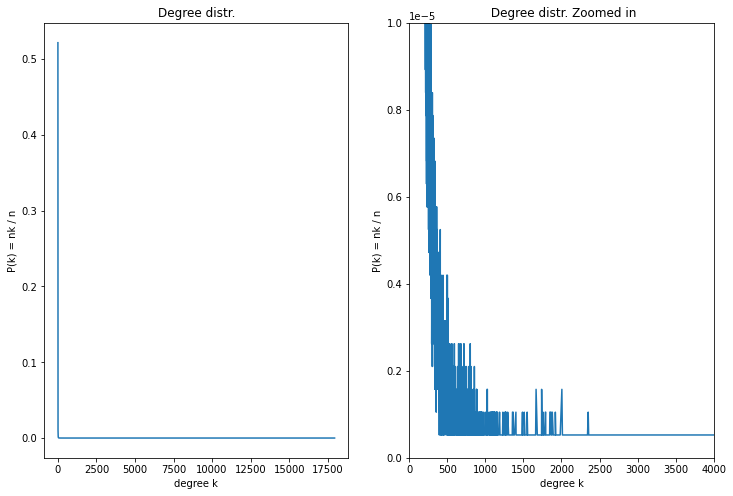

In [ ]:
output = call_functionality(1, num_graph=1)

### Functionality and Visualization 2

In [4]:
with open('graph_merge.json') as json_file:
    merge = json.load(json_file)

It takes in input:
- user/node <code>source</code>
- start time <code>[year, month]</code>
- end time <code>[year, month]</code>
- One of the following metrics: <code>"degree"</code> - <code>"closeness"</code> - <code>"pagerank"</code> - <code>"betweeness"</code>
- visualization option: boolean <code>visualize</code>
- weighted graph option: boolean <code>weighted</code>

It displays as output:
- the input node and its neighbouring nodes
- the monthly evolution of the metric over time

In [3]:
def functionality_2(source, merge, start, end, metric, visualize, weighted):
    # same year 
    start_period = f"{start[0]}-0{start[1]}"
    span = f"{start[0]}-0{start[1]}"
    end_period = f"{end[0]}-0{end[1]}"
    
    metric_story = []
    period_story = []
    
    while span != end_period:
        sgraph = f.sub_graph(start_period, span, merge)
        edges, directed, nodes = f.dictionaries(sgraph, weighted=weighted)
        
        if metric == "degree":
            print(f'Span: from {start_period} to {span}')
            period_story.append((f'to {span}'))
            metric_1 = f.degree_centrality(source, edges, nodes)
            metric_story.append(metric_1)
            span = f"{start[0]}-0{start[1]+1}"
            start[1] = start[1]+1
            print('')
            
        elif metric == "closeness":
            print(f'Span: from {start_period} to {span}')
            period_story.append((f'to {span}'))
            _, metric_2, _ = f.closeness_centrality(source, directed, nodes, stop_level=1000)
            metric_story.append(metric_2)
            span = f"{start[0]}-0{start[1]+1}"
            start[1] = start[1]+1
            print('')
        
        elif metric == "pagerank":
            print(f'Span: from {start_period} to {span}')
            period_story.append((f'to {span}'))
            metric_3 = f.pagerank(source, edges, nodes)
            metric_story.append(metric_3)
            span = f"{start[0]}-0{start[1]+1}"
            start[1] = start[1]+1
            print('')
        
            
    if visualize==True:
        sgraph = f.sub_graph(start_period, start_period, merge)
        edges, directed, nodes = f.dictionaries(sgraph, weighted=weighted)
        print(f'Source node {source} and its neighbours in {start_period}')
        f.visualize_graph(source, directed, edges)
    
    plt.figure(figsize=(8,4))
    plt.plot(period_story, metric_story, 'ro')
    plt.ylabel(f'{metric} centrality of node {source}')
    plt.xlabel(f'from {start_period}')

#### Degree centrality

The *degree centrality* of a node is equal to the ratio of its degree to the total nodes in the graph minus 1.
It measures the ability of a node to develop communication.

unweighted option

Span: from 2014-01 to 2014-01
The subgraph consists of 209668 nodes and 642479 edges.
The reference node 838976 has 169 neighboring nodes (60 out; 109 in) and its degree centrality is equal to 0.00080604

Span: from 2014-01 to 2014-02
The subgraph consists of 330268 nodes and 1267310 edges.
The reference node 838976 has 406 neighboring nodes (139 out; 267 in) and its degree centrality is equal to 0.00122931

Span: from 2014-01 to 2014-03
The subgraph consists of 436096 nodes and 1933652 edges.
The reference node 838976 has 448 neighboring nodes (152 out; 296 in) and its degree centrality is equal to 0.0010273

Span: from 2014-01 to 2014-04
The subgraph consists of 521508 nodes and 2550491 edges.
The reference node 838976 has 459 neighboring nodes (156 out; 303 in) and its degree centrality is equal to 0.00088014

Span: from 2014-01 to 2014-05
The subgraph consists of 596328 nodes and 3118510 edges.
The reference node 838976 has 459 neighboring nodes (156 out; 303 in) and its degree cen

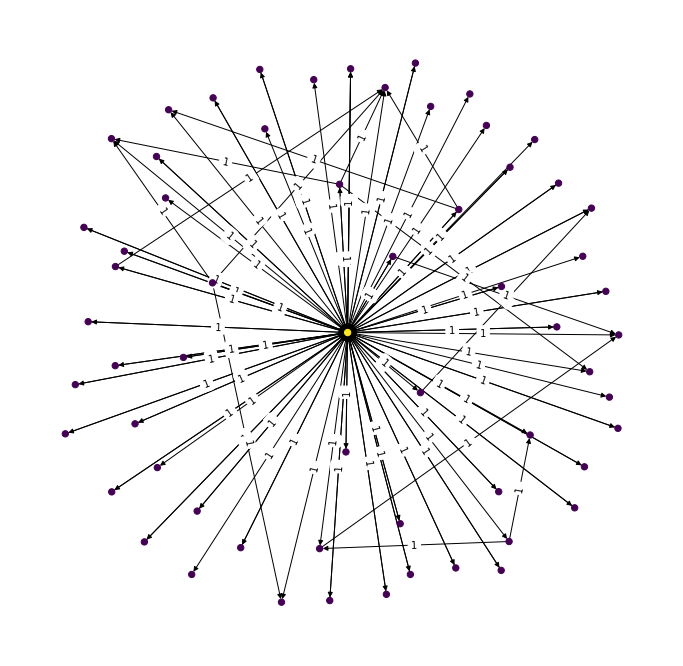

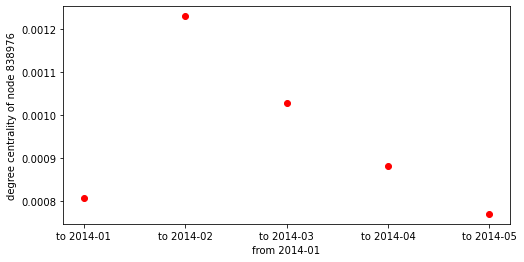

In [10]:
call_functionality(2, source=838976, merge=merge, start=[2014, 1], end=[2014, 6], metric="degree", visualize=True, weighted=False)

weighted option

Span: from 2014-01 to 2014-01
The subgraph consists of 209668 nodes and 642479 edges.
The reference node 838976 has 169 neighboring nodes (60 out; 109 in) and its degree centrality is equal to 0.00080604

Span: from 2014-01 to 2014-02
The subgraph consists of 330268 nodes and 1267310 edges.
The reference node 838976 has 406 neighboring nodes (139 out; 267 in) and its degree centrality is equal to 0.00122931

Span: from 2014-01 to 2014-03
The subgraph consists of 436096 nodes and 1933652 edges.
The reference node 838976 has 448 neighboring nodes (152 out; 296 in) and its degree centrality is equal to 0.0010273

Span: from 2014-01 to 2014-04
The subgraph consists of 521508 nodes and 2550491 edges.
The reference node 838976 has 459 neighboring nodes (156 out; 303 in) and its degree centrality is equal to 0.00088014

Span: from 2014-01 to 2014-05
The subgraph consists of 596328 nodes and 3118510 edges.
The reference node 838976 has 459 neighboring nodes (156 out; 303 in) and its degree cen

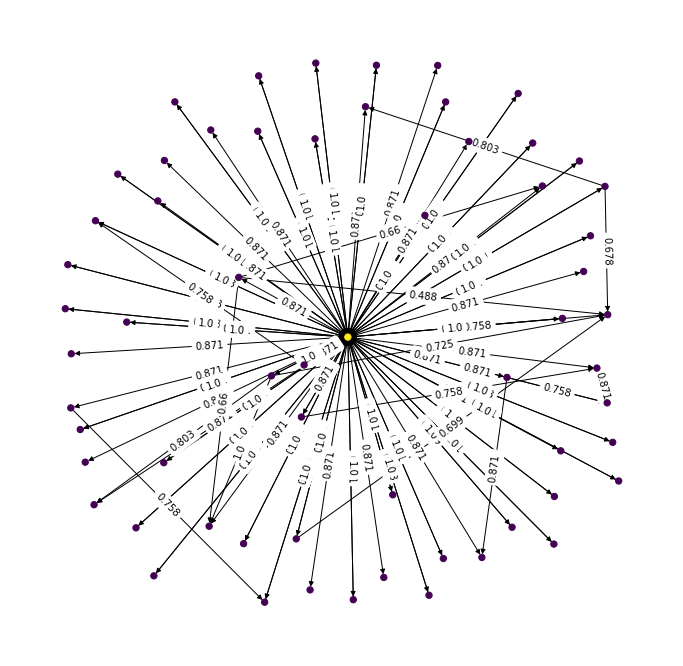

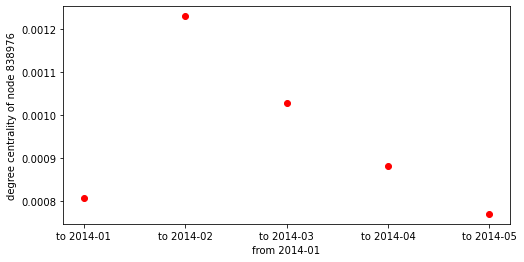

In [11]:
call_functionality(2, source=838976, merge=merge, start=[2014, 1], end=[2014, 6], metric="degree", visualize=True, weighted=True)

#### Closeness centrality

The *closeness centrality* of a reference node is equal to the ratio between the number of nodes potentially reachable following a directional path (in the case of a direct graph) which starts from it and the sum of the distances of the node from each reachable nodes.
It measures the proximity of a node to the rest of the network.

Span: from 2014-01 to 2014-01
Starting from the reference node (user) 838976 and following a directional path, it is possible to reach 105967 of 209668 nodes (users).
The farthest reachable node is 12 edges (unitary steps) far from the reference node.
Closeness centrality of the reference node is equal to 0.21944

Span: from 2014-01 to 2014-02
Starting from the reference node (user) 838976 and following a directional path, it is possible to reach 181055 of 330268 nodes (users).
The farthest reachable node is 11 edges (unitary steps) far from the reference node.
Closeness centrality of the reference node is equal to 0.245

Span: from 2014-01 to 2014-03
Starting from the reference node (user) 838976 and following a directional path, it is possible to reach 249528 of 436096 nodes (users).
The farthest reachable node is 10 edges (unitary steps) far from the reference node.
Closeness centrality of the reference node is equal to 0.25162

Span: from 2014-01 to 2014-04
Starting from the refere

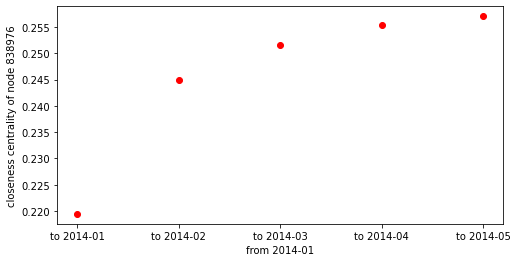

In [23]:
call_functionality(2, source=838976, merge=merge, start=[2014, 1], end=[2014, 6], metric="closeness", visualize=False, weighted=False)

#### PageRank centrality

*PageRank centrality* of a reference node is affected by the number of links it receives, the link propensity of the linkers, and the centrality of the linkers.

Span: from 2014-01 to 2014-01
Pagerank centrality of node 838976 is equal to 2.0985558120457104e-05

Span: from 2014-01 to 2014-02
Pagerank centrality of node 838976 is equal to 1.3322513837247327e-05

Span: from 2014-01 to 2014-03
Pagerank centrality of node 838976 is equal to 8.140409451130026e-06

Span: from 2014-01 to 2014-04
Pagerank centrality of node 838976 is equal to 5.17729354103868e-06

Span: from 2014-01 to 2014-05
Pagerank centrality of node 838976 is equal to 4.5277095826457924e-06



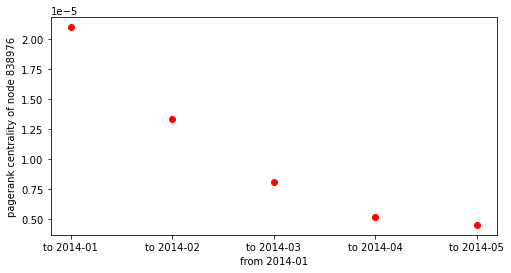

In [5]:
call_functionality(2, source=838976, merge=merge, start=[2014, 1], end=[2014, 6], metric="pagerank", visualize=False, weighted=False)

#### Betweeness centrality

The *betweeness centrality* of a reference node is equal to the ratio of the sum of the ratios of the number of shortest paths to the number of shortest paths passing through the reference node for each pair of nodes, and the number of pairs of nodes not including the reference one. It measures the inclination of a node to control communications in the network.

Using our function, given the high computational cost, we were unable to compute this metric over our minimum interval (one month). Check the function <code>f.betweeness_centrality</code>
We also tried a test with the build-in function of networkx and after two hours we stopped the process.

### Functionality and Visualization 3

It takes in input:
- node list <code>node_list</code> the list of nodes to pass through orderly
- start time <code>'year-month'</code>
- end time <code>'year-month'</code>
- visualization option: boolean <code>visualize</code>
- weighted graph option: boolean <code>weighted</code>

It displays as output:
- if a shortest ordered route exists, displays it

In [5]:
def functionality_3(node_list, start_str, end_str, visualize, weighted):
    # input list of nodes to pass on in the "walk"
    with open('graph_merge.json') as json_file:
        merge = json.load(json_file)
        
    sgraph = f.sub_graph(start_str, end_str, merge)
    edges, directed, nodes = f.dictionaries(sgraph, weighted=weighted)
    walk, distance = f.shortest_walk(node_list, edges, directed, nodes)
    
    pri_list = f.flatten([l[:len(l)-1] for l in walk])
    pri_list.append(walk[-1][-1])
    
    print(f'The shortest ordered route for the entry path {node_list} is {pri_list}')
    print(f'The overall distance in equal to {sum(distance)}')
    
    if visualize == True:
        G = nx.DiGraph()
        for i in range(len(pri_list)-1):
            G.add_edge(pri_list[i],pri_list[i+1]) #, weight=edges[(pri_list[i], pri_list[i+1])])
          
        node_list.pop(0)
        node_list.pop(-1)
        
        pos = nx.layout.spring_layout(G)   
        nx.draw_networkx_nodes(G, pos=pos, nodelist=pri_list, node_color='#fff3b0', label='Other nodes', node_size = 600, alpha = 0.5)
        nx.draw_networkx_nodes(G, pos=pos, nodelist=[pri_list[0]],node_color='#9e2a2b', label='Initial User', node_size = 600, alpha = 0.5)
        nx.draw_networkx_nodes(G, pos=pos, nodelist=[pri_list[-1]], node_color='#335c67', label='End User', node_size = 600, alpha = 0.5)
        nx.draw_networkx_nodes(G, pos=pos, nodelist=node_list, node_color='#e09f3e', label='Users you must pass through', node_size = 600, alpha = 0.5)
        plt.tight_layout()
        plt.legend(scatterpoints = 1, markerscale = 0.2)
        color_map = ['#9e2a2b' if node == pri_list[0] else '#335c67' if node == pri_list[-1]  else '#e09f3e' if node in node_list else '#fff3b0' for node in pri_list]
        nx.draw(G, with_labels = True, node_color=color_map, alpha = 0.5, pos = pos, arrowsize=15, connectionstyle='arc3,rad=0.05', node_size = 600)
    
    return walk, distance

The shortest ordered route for the entry path [838976, 2391782, 449330, 509934, 1626286] is [838976, 1968, 470005, 112407, 2391782, 1254944, 449330, 2070674, 1177719, 2454714, 509934, 1197406, 1626286]
The overall distance in equal to 10.328


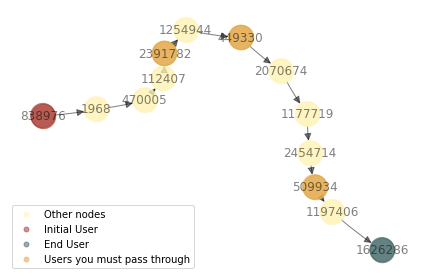

In [7]:
walk, distance = functionality_3(node_list=[838976, 2391782, 449330, 509934, 1626286], start_str='2014-01', end_str='2014-01', visualize=True, weighted=True)

### Functionality and Visualization 4

*Note:
In the implementation of this functionality we have considered only one time interval and detached two nodes inside it (as per adjustment for this function).
Unfortunately the subset used is not very representative because there are few edges between the nodes, but we have also tested the function on examples created ad hoc.*

In [2]:
with open('graph_merge.json') as json_file:
    graph = json.load(json_file)

In [3]:
g1 = f.sub_graph("2014-08", "2014-08", graph)

In [4]:
keys = random.sample(list(g1), 5000)
node1 = keys[0]
node2 = keys[-1]
#values = [g1[k] for k in keys]
g2 = {}
for key in keys:
    g2[int(key)] = g1[key]

In [5]:
edges = defaultdict()
g = defaultdict()
# nodes: set of all nodes in the sub-graph
nodes = set()

for source in g2.keys():

    aux = list(itertools.chain(*g2[source]))
    g[int(source)] = list()

    for target in aux:

        if target not in g[int(source)]:
              g[int(source)].append(target)

In [6]:
for node in g:
    neighbors = [node_weight for node_weight in g[node] if node_weight[0] in g.keys()]
    g[node] = neighbors

In [32]:
node_1 = input("Node 1:")
node_2 = input("Node 2:")

Node 1:200317
Node 2:1120027


In [33]:
cutValue, nodes = f.minCut(node_1, node_2, g)

3593846 - 1120027


In [55]:
# minumum number of edges to cut
cutValue

1

In [31]:
nodes

[(3593846, 1120027)]

In the subgraph green nodes are the ones we want to separate. We used the same color (green) to represent the edges belonging to the main cut.

No handles with labels found to put in legend.


[200317]
[200317, 3593846, 567435, 1120027]


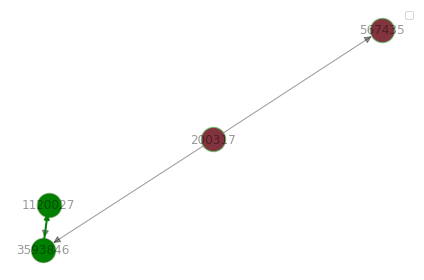

In [51]:
f.visualization_4(node_1, node_2, g)

### Algorithmic question

This function takes as input:


*   n= number of kids
*   k= list of pairs

First, all couples are separated into different dorms.
Then we check if there are no children "arguing" in the same dormitory and if so we add the others as well.

There are two loops over k and over n, hence the algorithm is linear in n and k.

In [8]:
def alg(n, k):

    m=range(1,n+1)
    d_1 = set() #dorm 1
    d_2 = set() #dorm 2
    
    kids = set()

    
    
    #Separate the pairs
    for i in k:
        kids.add(i[0]) 
        d_1.add(i[0]) 
        kids.add(i[1]) 
        d_2.add(i[1]) 
        
        
            
    #check if there are kids who can't be together
    
    for i in k:
        if(((i[0] in d_1) and (i[1] in d_1)) or (i[0] in d_2) and (i[1] in d_2)):
            print("It's not possible to separate all the pairs")
            return 
    
    #Rest of kids
    for i in m:
        if((i not in d_1) and (i not in d_2)):
            d_1.add(i)
            
    
    
    print("First dormitory:", d_1)
    print("Second dormitory:",d_2)

In [9]:
n = 8
k = [(2,5), (2,4),(6,5)]
alg(n, k)

First dormitory: {1, 2, 3, 6, 7, 8}
Second dormitory: {4, 5}


In [10]:
n = 4
k = [(1,3),(1,2),(2,3)]
alg(n, k)

It's not possible to separate all the pairs
